#**Chiangmai_PM2.5_Forcasting**

## 1. Set up and import data

In [80]:
from google.colab import files

In [81]:
uploaded = files.upload()

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [83]:
df = pd.read_csv('/content/chiang-mai-air-quality.csv')
df.sample(10)

,date,pm25,pm10,o3,no2,so2,co
689,2022/4/11,131,61,28,3,,
651,2022/9/3,63,24,,,,
2552,2017/2/19,151,67,24,27,,
2080,2018/4/30,79,30,18,4,,
598,2022/7/12,42,21,,,,
1079,2021/5/6,75,31,26,1,,
3047,2015/12/26,,41,36,17,1,10
1084,2021/5/11,61,28,18,1,,
2122,2018/6/11,39,27,22,5,,
1843,2019/3/7,109,64,20,8,,


In [84]:
df.replace(' ', np.nan, inplace=True)

In [85]:
df.shape

(3698, 7)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3698 non-null   object
 1    pm25   2954 non-null   object
 2    pm10   3328 non-null   object
 3    o3     2847 non-null   object
 4    no2    2791 non-null   object
 5    so2    971 non-null    object
 6    co     957 non-null    object
dtypes: object(7)
memory usage: 202.4+ KB


In [87]:
df.describe()

,date,pm25,pm10,o3,no2,so2,co
count,3698,2954,3328,2847,2791,971,957
unique,3698,197,124,89,46,33,28
top,2024/5/1,57,26,18,6,1,6
freq,1,61,102,124,243,480,104


drop any columns that are not needed for focus and sort the dates.

In [88]:
df = df.rename(columns={' pm25': 'pm2.5'})
df.dropna(subset=['pm2.5'], inplace=True)

In [89]:
columns_to_keep = ['date', 'pm2.5']
df = df[columns_to_keep]
df = df.sort_values(by='date', ascending=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,pm2.5
date,
2016-01-10,90
2016-01-11,112
2016-01-12,121
2016-01-13,127
2016-01-14,119
...,...
2024-05-05,159
2024-05-06,178
2024-05-07,151


##2. Exploratory Data Analysis

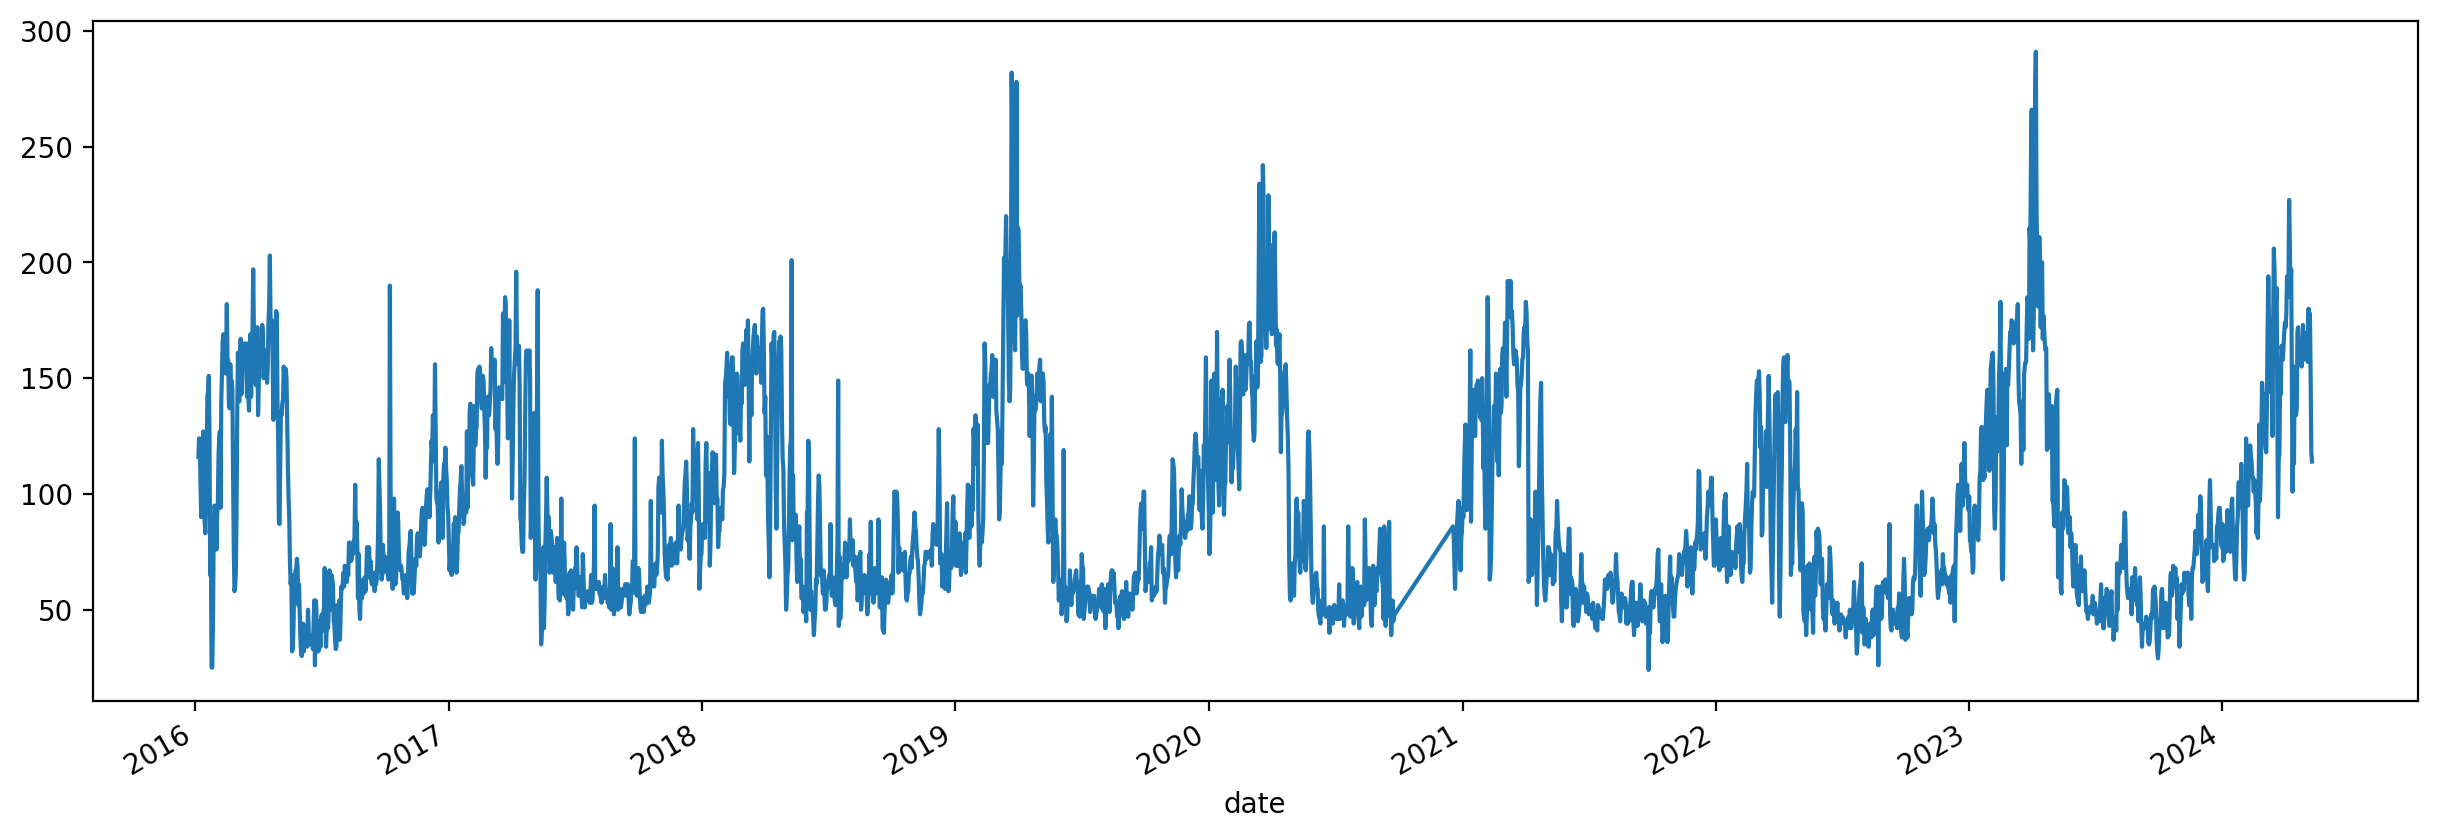

In [90]:
df['pm2.5'] = pd.to_numeric(df['pm2.5'], errors='coerce')
plt.figure(figsize = (15,5))
df['pm2.5'].plot();

## 3. Time series forcasting

In [91]:
df_train = df.loc[:'2023-12-31']
df_test = df.loc['2024-01-01':]

In [92]:
df_train

,pm2.5
date,
2016-01-10,90
2016-01-11,112
2016-01-12,121
2016-01-13,127
2016-01-14,119
...,...
2023-09-05,56
2023-09-06,43
2023-09-07,34


In [93]:
df_test

,pm2.5
date,
2024-01-01,87
2024-01-10,82
2024-01-11,80
2024-01-12,75
2024-01-13,80
...,...
2024-05-05,159
2024-05-06,178
2024-05-07,151


### 3.1 ARIMA

First, we will see if our time series is stationary or not using the ADF Test method because the ARIMA model works well with stationary data.

In [94]:
adftest = adfuller(df_train['pm2.5'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series is non-stationary")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])

ADF Test Results
Null Hypothesis: The series is non-stationary
ADF-Statistic: -4.603366565305837
P-Value: 0.0010177476738698742
Number of lags: 13
Number of observations: 2810
Critical Values: {'1%': -3.9619953500768723, '5%': -3.4120535663362075, '10%': -3.1279706404382432}


*   Since P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary.so there is no need to transform our time series.




Next, we will look at the ACF and PACF plots to select p and q values. Suitable for ARIMA model.

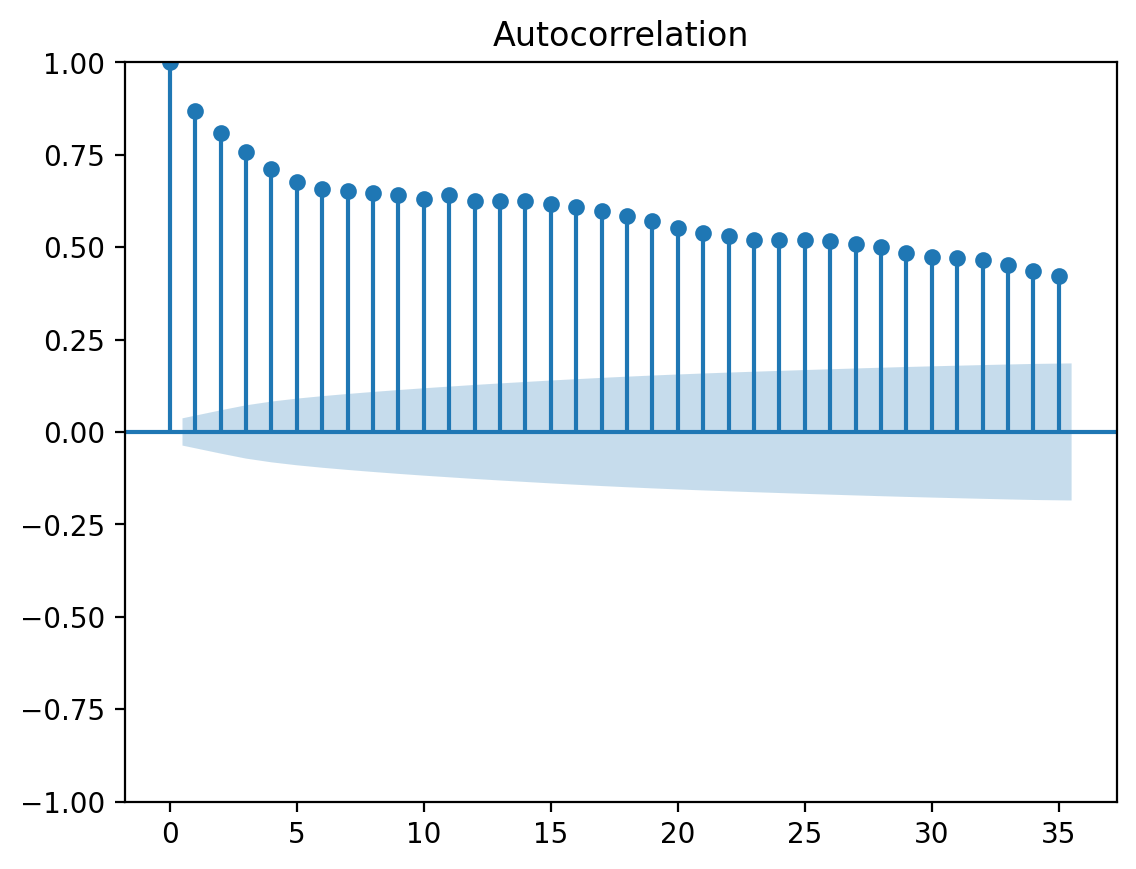

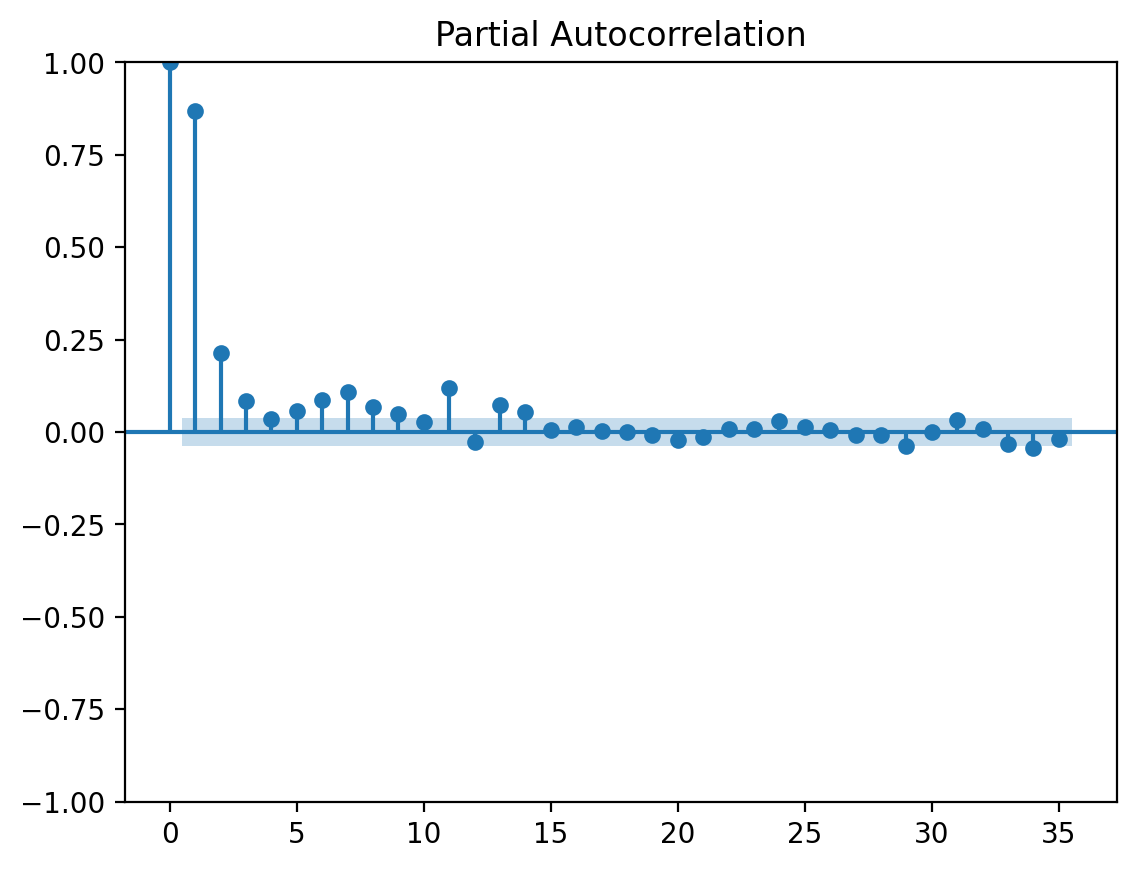

In [95]:
acf = plot_acf(df_train['pm2.5'])
pacf = plot_pacf(df_train['pm2.5'])

*   In this case we will look at the PACF plot by considering the value of each lag. Then should we choose ARIMA(2,d,0)




The next step is to determine the optimal 'd' value for ARIMA.

In [ ]:
d_values = range(0, 5)

min_rmse = float('inf')
best_d = None

for d in d_values:

    model = ARIMA(df_train, order=(2, d, 0))
    result = model.fit()

    forecast = result.forecast(len(df_test))

    rmse = np.sqrt(mean_squared_error(df_test, forecast))

    if rmse < min_rmse:
        min_rmse = rmse
        best_d = d

In [97]:
print(f"Best d value: {best_d} (RMSE: {min_rmse})")

Best d value: 2 (RMSE: 29.081158656860342)


Now, we got our best model with lowest rmse ARIMA(2,2,0). Next, let's look at the plot.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

<Axes: xlabel='date'>

<Figure size 2000x500 with 0 Axes>

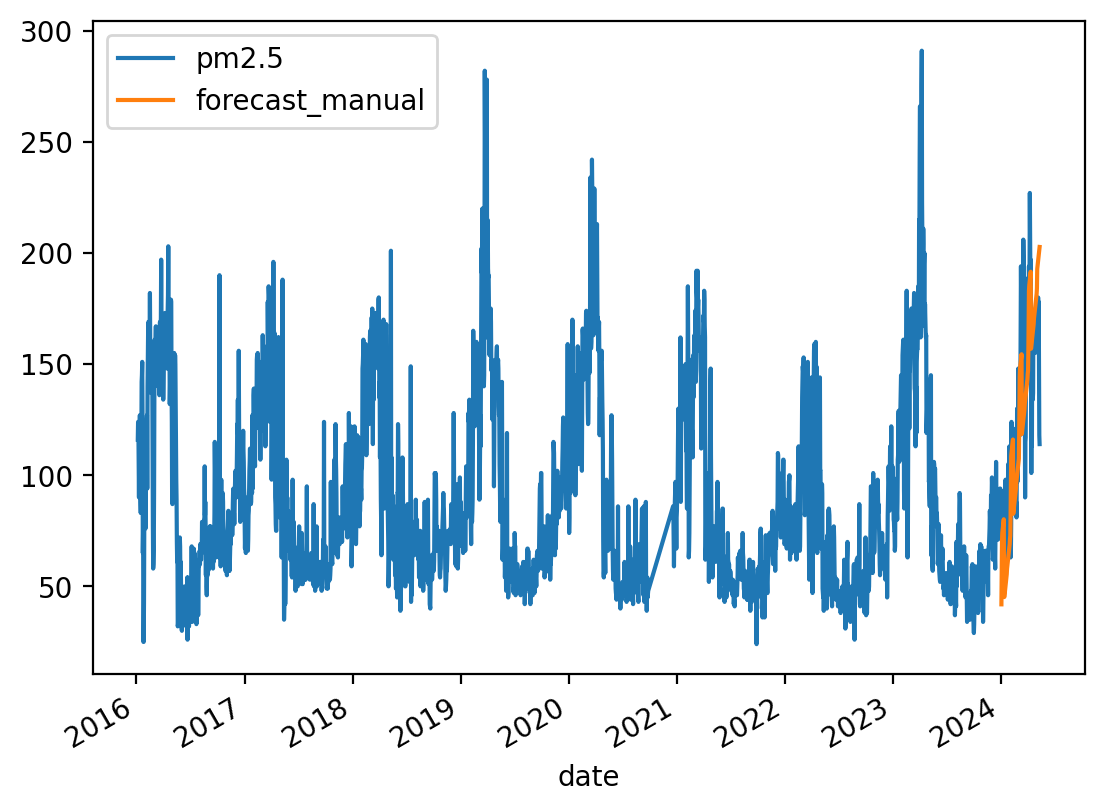

In [112]:
model = ARIMA(df_train, order=(2, 2, 0))
result = model.fit()
forecast = result.forecast(len(df_test))
ARIMA_rmse = np.sqrt(mean_squared_error(df_test, forecast))

df['forecast_manual'] = [None]*len(df_train) + list(forecast)

plt.figure(figsize = (20,5))
df.plot()

### 3.2 SARIMAX